# Introduction

![title](../tweepy_image.jpeg)

This project will investigate Twitter activity from the day of the 2020 U.S. Election, November 3rd (as well as from the days afterwards, as the election evidently did not end that night). I have used the Twitter API to collect all tweets containing the hashtag #Election2020 in an effort to gather a dataset reflecting social media users' thoughts and opinions during the elction in a neutral, nonpartisan way. The tweets collected were those posted between ______ and ______.

With this dataset, we will first create some visualizations to illuminate some basic trends from Election Night (or Week). These could be questions such as:
- What kinds of users were using Twitter to voice their opinions? Can we see how many followers these users had, or how many interactions their tweets recieved?
- What were the most relevant hashtags that were used?
- Can we break down tweets by state?
- How did the volume of tweets fluctuate throughout the election? More specifically, can we see fluctuations in say, the use of particular hashtags or amount of activity from specific states, over time?

Next, we will dig deeper into the text (i.e., the actual content of the tweet itself). We will try to implement natural language processing practices to uncover key aspects such as how tweets containing "Biden" compared to those with "Trump" in them, as an example. This will lead us to the central part of this project: sentiment analysis. We will look into the sentiments of the tweets across Biden/Trump tweets, across states, across the most popular tweets, and so on. Our key initiative is to look at just how closely the sentiment of users on Twitter during the elction lines up with the actual events of the election as results were unfolding. Can we draw a correlation, or even a causation between how the election was going as different states were being designated red or blue versus how people were feeling on Twitter? Let's find out...

# Import Libraries

In [1]:
# Data manipulation libraries
import numpy as np
import pandas as pd
from itertools import chain
import string
import re
import ast
from collections import Counter

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from wordcloud import WordCloud
from mpl_toolkits.basemap import Basemap
from matplotlib.colors import rgb2hex, Normalize
from matplotlib.cm import ScalarMappable
from matplotlib.patches import Polygon
from matplotlib.colorbar import ColorbarBase

# Tweet preprocessing library (source: https://pypi.org/project/tweet-preprocessor/)
import preprocessor as p

# Natural langauge processing libraries
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize, TweetTokenizer
from nltk import FreqDist
from sklearn.feature_extraction.text import CountVectorizer
from textblob import TextBlob

# Overview of Dataset

## Import Data

In [2]:
# Load data
df = pd.read_csv('../data/raw/election_tweets.csv')

## Add Additional Columns

In [4]:
# Parse created_at column and add new columns indicating month, day, hour tweet was posted
df['created_at_month'] = df['created_at'].apply(lambda x: re.split(r'-|\s|:', x)[1])
df['created_at_day'] = df['created_at'].apply(lambda x: re.split(r'-|\s|:', x)[2])
df['created_at_hour'] = df['created_at'].apply(lambda x: re.split(r'-|\s|:', x)[3])

In [5]:
# Preview data
df.head()

,tweet_id,created_at,text,hashtags,retweets_count,favorites_count,user_id,user_name,user_screen_name,user_desc,user_location,user_statuses_count,created_at_month,created_at_day,created_at_hour
0,1322659618837975045,2020-10-31 22:00:01,"During this election time, let us pray for the...","['Election2020', 'USElection2020', 'Vote', 'Pr...",0,0,971218837,Shalom World,ShalomWorldTV,GOD'S OWN CHANNEL,NaN,5317,10,31,22
1,1322659616552079361,2020-10-31 22:00:01,"This year, Nevada could eclipse the overall tu...",['Election2020'],0,0,15358759,Las Vegas Review-Journal,reviewjournal,Nevada's largest newspaper and the most reliab...,"Las Vegas, NV",199665,10,31,22
2,1322659615860019200,2020-10-31 22:00:00,🗳️ Friendly reminder that early voting ends TO...,['Election2020'],0,0,551520612,Make the Road Action 🦋,MaketheRoadAct,"Building power, promoting policy solutions, & ...",New York,10684,10,31,22
3,1322659614492516353,2020-10-31 22:00:00,Why I Vote ✔️\n\n@BSUBeaverSoccer's Alyssa Stu...,"['BeaverTerritory', 'Election2020']",0,0,25717467,Bemidji St. Beavers,BSUBeavers,"The latest news, scores and upcoming Beaver At...","Bemidji, Minn.",37370,10,31,22
4,1322659614282842113,2020-10-31 22:00:00,Be sure to listen to this weeks #podcast where...,"['podcast', 'Debates2020', 'ElectionDay', 'Deb...",0,0,833726321381498882,The Statecraft Observer Podcast † 🇺🇸 🎙️,StatecraftTweet,Brandon D. Keller: I am a conservative politi...,NaN,6476,10,31,22


In [7]:
print("We have our data now: there are {} tweets and {} features for us to work with.".format(df.shape[0], df.shape[1]))

We have our data now: there are 10000 tweets and 15 features for us to work with.


In [8]:
df.describe()

,tweet_id,retweets_count,favorites_count,user_id,user_statuses_count
count,1.000000e+04,10000.000000,10000.000000,1.000000e+04,1.000000e+04
mean,1.322617e+18,1.032400,3.547300,3.148608e+17,2.563971e+04
std,2.328818e+13,30.146944,96.821292,4.940289e+17,5.883530e+04
min,1.322570e+18,0.000000,0.000000,6.590000e+03,1.000000e+00
25%,1.322600e+18,0.000000,0.000000,8.701021e+07,1.971750e+03
50%,1.322619e+18,0.000000,0.000000,8.828599e+08,7.319500e+03
75%,1.322635e+18,0.000000,1.000000,8.208537e+17,2.376525e+04
max,1.322660e+18,2893.000000,9173.000000,1.322628e+18,1.707172e+06


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   tweet_id             10000 non-null  int64 
 1   created_at           10000 non-null  object
 2   text                 10000 non-null  object
 3   hashtags             10000 non-null  object
 4   retweets_count       10000 non-null  int64 
 5   favorites_count      10000 non-null  int64 
 6   user_id              10000 non-null  int64 
 7   user_name            10000 non-null  object
 8   user_screen_name     10000 non-null  object
 9   user_desc            9195 non-null   object
 10  user_location        7778 non-null   object
 11  user_statuses_count  10000 non-null  int64 
 12  created_at_month     10000 non-null  object
 13  created_at_day       10000 non-null  object
 14  created_at_hour      10000 non-null  object
dtypes: int64(5), object(10)
memory usage: 1.1+ MB


In [10]:
df.columns

Index(['tweet_id', 'created_at', 'text', 'hashtags', 'retweets_count',
       'favorites_count', 'user_id', 'user_name', 'user_screen_name',
       'user_desc', 'user_location', 'user_statuses_count', 'created_at_month',
       'created_at_day', 'created_at_hour'],
      dtype='object')

# Exploratory Data Analysis

In [178]:
# Set style for ensuing plots
plt.style.use('fivethirtyeight')
sns.set_palette('muted')

In [179]:
# Set font sizes for our plots
plt.rc('font', size = 14)
plt.rc('axes', labelsize = 18)
plt.rc('legend', fontsize = 18)
plt.rc('axes', titlesize = 28)
plt.rc('figure', titlesize = 28)

## User Statistics

In this section, we provide an overview of the users who tweeted during the election, just so we get a sense of who tweeted, and how well their tweets were received. We will look at their history on Twitter - their followers/retweets/favorites accrued - and potentially single out some of the "top" users and carefully look at their tweets in particular.

In [180]:
# Average number of "statuses"/tweets users in the data had at the time of tweeting
print("The users in this dataset had an average of {} tweets posted".format(df['user_statuses_count'].mean()))
print("The users in this dataset had a median of {} tweets posted".format(df['user_statuses_count'].median()))

The users in this dataset had an average of 25639.7148 tweets posted
The users in this dataset had a median of 7319.5 tweets posted


Let's create a plot to see the breakdown of users' statuses totals in more detail.

In [181]:
# Sort tweet/favorite/retweet totals into bins for plotting purposes
num_statuses_dict = {
        'Less than 1,000': 0,
        '1,000 to 10,000': 0,
        '10,000 to 100,000': 0,
        'More than 100,000': 0
    }

def sort_into_bins(x, dictionary):
    if dictionary == num_statuses_dict:    # For sorting users
        if (x < 1000):
            dictionary['Less than 1,000'] += 1
            return "Less than 1,000"
        elif (1000 <= x < 10000):
            dictionary['1,000 to 10,000'] += 1
            return "1,000 to 10,000"
        elif (10000 <= x < 100000):
            dictionary['10,000 to 100,000'] += 1
            return "10,000 to 100,000"
        else: 
            dictionary['More than 100,000'] += 1
            return "More than 100,000"
    else:                                  # For sorting tweets
        if (x < 1):
            dictionary['None'] += 1
            return "None"
        elif (1 <= x < 10):
            dictionary['1 to 10'] += 1
            return "1 to 10"
        elif (10 <= x < 100):
            dictionary['10 to 100'] += 1
            return "10 to 100"
        else: 
            dictionary['More than 100'] += 1
            return "More than 100"

In [182]:
df['num_tweets'] = df['user_statuses_count'].apply(lambda x: sort_into_bins(x, num_statuses_dict));

In [183]:
num_statuses_dict

{'Less than 1,000': 1639,
 '1,000 to 10,000': 4022,
 '10,000 to 100,000': 3780,
 'More than 100,000': 559}

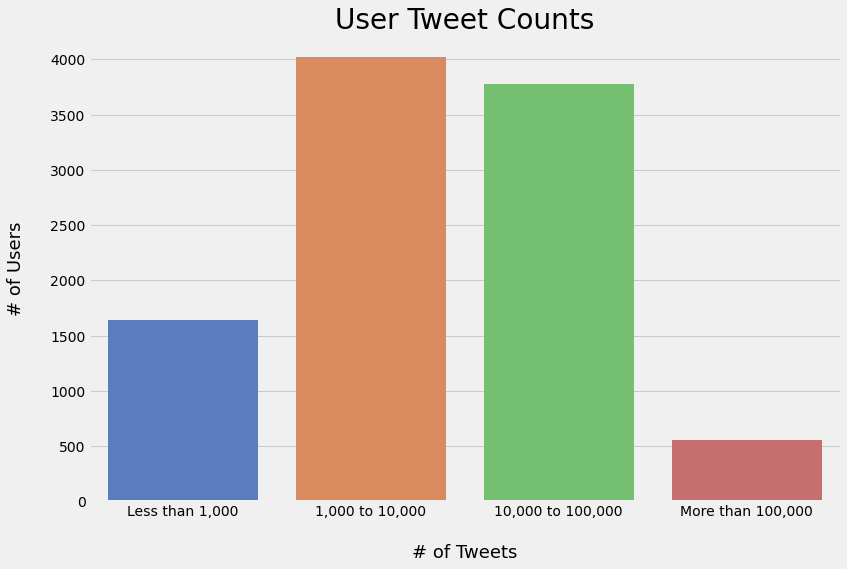

In [184]:
num_statuses_df = pd.DataFrame(list(num_statuses_dict.items()))
num_statuses_df.columns = ['Bin', 'Count']
num_statuses_df = num_statuses_df.reset_index(drop=True)
num_statuses_df

fig, ax = plt.subplots(figsize = (12, 8))

ax = sns.barplot(x = num_statuses_df.Bin, y = num_statuses_df.Count)

ax.set_title("User Tweet Counts")
ax.set_xlabel("# of Tweets", labelpad = 25)
ax.set_ylabel("# of Users", labelpad = 25);

## Tweets with the Most Retweets/Favorites

In [185]:
num_retweets_dict = {
        'None': 0,
        '1 to 10': 0,
        '10 to 100': 0,
        'More than 100': 0
    }

In [186]:
df['num_retweets'] = df['retweets_count'].apply(lambda x: sort_into_bins(x, num_retweets_dict));

In [187]:
num_retweets_dict

{'None': 8646, '1 to 10': 1228, '10 to 100': 117, 'More than 100': 9}

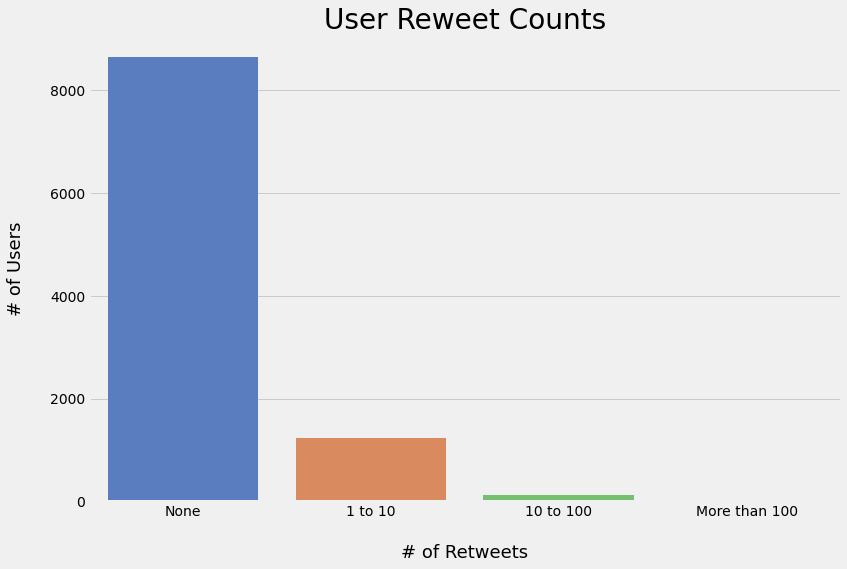

In [188]:
num_retweets_df = pd.DataFrame(list(num_retweets_dict.items()))
num_retweets_df.columns = ['Bin', 'Count']
num_retweets_df = num_retweets_df.reset_index(drop=True)
num_retweets_df

fig, ax = plt.subplots(figsize = (12, 8))

ax = sns.barplot(x = num_retweets_df.Bin, y = num_retweets_df.Count)

ax.set_title("User Reweet Counts")
ax.set_xlabel("# of Retweets", labelpad = 25)
ax.set_ylabel("# of Users", labelpad = 25);

In [189]:
num_favorites_dict = {
        'None': 0,
        '1 to 10': 0,
        '10 to 100': 0,
        'More than 100': 0
    }

In [190]:
df['num_favorites'] = df['favorites_count'].apply(lambda x: sort_into_bins(x, num_favorites_dict));

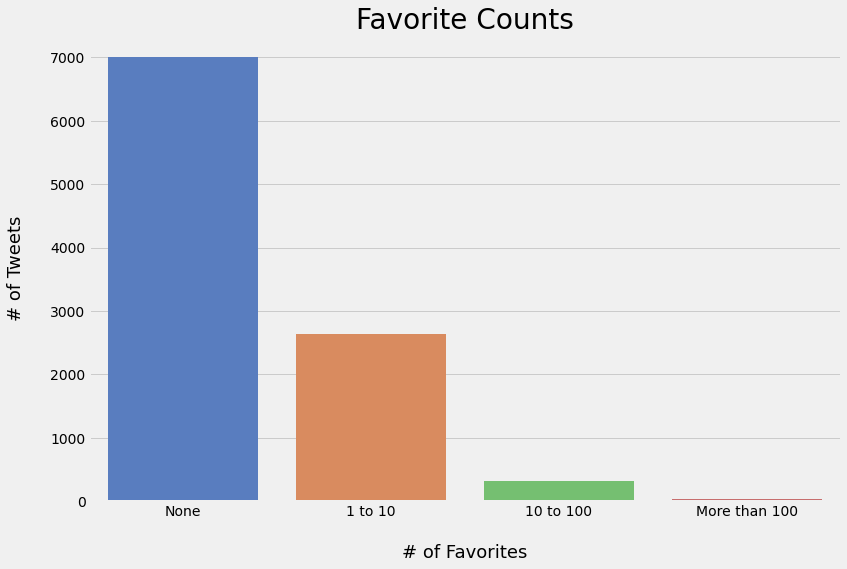

In [191]:
num_favorites_df = pd.DataFrame(list(num_favorites_dict.items()))
num_favorites_df.columns = ['Bin', 'Count']
num_favorites_df = num_favorites_df.reset_index(drop=True)
num_favorites_df

fig, ax = plt.subplots(figsize = (12, 8))

ax = sns.barplot(x = num_favorites_df.Bin, y = num_favorites_df.Count)

ax.set_title("Favorite Counts")
ax.set_xlabel("# of Favorites", labelpad = 25)
ax.set_ylabel("# of Tweets", labelpad = 25);

In [192]:
# Change display settings so more the text is printed on-screen
pd.options.display.max_colwidth = 100

In [193]:
# A quick look at the most retweeted tweets
most_retweeted = df.sort_values(by=['retweets_count'], ascending = False)[['text', 'retweets_count']]
for i, t in enumerate(most_retweeted['text'].head(5)):
    print(t + ' ({} Retweets)'.format(most_retweeted['retweets_count'].iloc[i]) + '\n\n')

Happening Now—President Trump arrives in Reading, Pennsylvania for a MAKE AMERICA GREAT AGAIN rally with Great American Patriots! Let’s do this PENNSYLVANIA! Get out and VOTE #TrumpPence2020, and let’s WIN, WIN, WIN! 

#Election2020 #MAGA🇺🇸🦅 
🌐https://t.co/zqgeZML9Hf https://t.co/lpCmcG3Aq5 (2893 Retweets)


2020 Electoral College Forecast Map 
Donald Trump vs Joe Biden
October 31~ 2020. PT.II
My Analysis Post: https://t.co/JfgWEDsA81
Post will continue to be updated
#ElectoralMap #ElectoralCollegeMap2020  #Election2020
#ForecastMAP #Election2020Map #ElectoralCollege 
#Elections2020 https://t.co/457uKwPbqy (654 Retweets)


“Joe Biden is my brother. I love Joe Biden and he will be a great president.”

@BarackObama says of Biden during the pair's first joint campaign rally in Flint, Michigan #Election2020 https://t.co/7Pp0ClQnY6 (242 Retweets)


Listen to this smart and cute kid!

#Election2020 #MAGA🇺🇸🦅

https://t.co/QSMx54GDSF (177 Retweets)


#Election2020 Stumbled on this really nice 

What about the tweets with the most favorites?

In [194]:
most_favorited = df.sort_values(by=['favorites_count'], ascending = False)[['text', 'favorites_count']]
for i, t in enumerate(most_favorited['text'].head(5)):
    print(t + ' ({} Favorites)'.format(most_favorited['favorites_count'].iloc[i]) + '\n\n')

Happening Now—President Trump arrives in Reading, Pennsylvania for a MAKE AMERICA GREAT AGAIN rally with Great American Patriots! Let’s do this PENNSYLVANIA! Get out and VOTE #TrumpPence2020, and let’s WIN, WIN, WIN! 

#Election2020 #MAGA🇺🇸🦅 
🌐https://t.co/zqgeZML9Hf https://t.co/lpCmcG3Aq5 (9173 Favorites)


2020 Electoral College Forecast Map 
Donald Trump vs Joe Biden
October 31~ 2020. PT.II
My Analysis Post: https://t.co/JfgWEDsA81
Post will continue to be updated
#ElectoralMap #ElectoralCollegeMap2020  #Election2020
#ForecastMAP #Election2020Map #ElectoralCollege 
#Elections2020 https://t.co/457uKwPbqy (1779 Favorites)


Was looking through old pictures and found this one of my mother voting in 2016. She didn't get to see me cast my first vote but I know that it would have made her proud. #GoVote #Election2020 https://t.co/aO7yYix8Bm (1501 Favorites)


GOP friend in Missouri after voting Saturday:

“Well, I did it. I’m a Biden Republican, and God bless America.”

Country Over Part

Okay, so the two sets of tweets are mostly the same, as expected, but not all of them match up. Also as expected, these tweets have significantly more favorites than retweets.

Later on, we'll look specifically at the most popular tweets in the dataset and closely examine their sentiment and 
partisanship. We will store the indices for the most retweeted/favorited tweets here:

In [195]:
most_rt_index = most_retweeted.iloc[0:10, :].index.tolist()
most_fav_index = most_favorited.iloc[0:10, :].index.tolist()
most_rt_index

[3298, 9997, 7279, 8757, 6323, 8634, 8042, 7078, 9743, 9675]

In [196]:
df.iloc[most_rt_index, :]

,tweet_id,created_at,text,hashtags,retweets_count,favorites_count,user_id,user_name,user_screen_name,user_desc,...,created_at_hour,num_tweets,num_retweets,num_favorites,user_state,text_cleaned,text_lemmatized,biden,trump,polarity
3298,1322629061974347776,2020-10-31 19:58:36,"Happening Now—President Trump arrives in Reading, Pennsylvania for a MAKE AMERICA GREAT AGAIN ra...","['TrumpPence2020', 'Election2020', 'MAGA']",2893,9173,620571475,Dan Scavino🇺🇸🦅,DanScavino,Personal Twitter Account,...,19,"10,000 to 100,000",More than 100,More than 100,NaN,happening nowpresident trump arrives in reading pennsylvania for a make america great again rall...,"[happening, nowpresident, trump, arrives, reading, pennsylvania, make, america, great, rally, gr...",False,True,0.666667
9997,1322570275204915201,2020-10-31 16:05:00,2020 Electoral College Forecast Map \nDonald Trump vs Joe Biden\nOctober 31~ 2020. PT.II\nMy Ana...,"['ElectoralMap', 'ElectoralCollegeMap2020', 'Election2020', 'ForecastMAP', 'Election2020Map', 'E...",654,1779,4547869279,"StatesPoll,com",StatesPoll,"Election Polling Analyst(not biased, 100% neutral)\nMy 2016 Election Final forecast Map Tweet:\n...",...,16,"More than 100,000",More than 100,More than 100,NaN,electoral college forecast map donald trump vs joe bidenoctober ptiimy analysis post will cont...,"[electoral, college, forecast, map, donald, trump, v, joe, bidenoctober, ptiimy, analysis, post,...",False,True,0.000000
7279,1322602814493855746,2020-10-31 18:14:18,“Joe Biden is my brother. I love Joe Biden and he will be a great president.”\n\n@BarackObama sa...,['Election2020'],242,888,252751061,Bloomberg QuickTake,QuickTake,"The biggest stories, the moment they happen, from around the globe. Subscribe to our weekly news...",...,18,"More than 100,000",More than 100,More than 100,NaN,joe biden is my brother i love joe biden and he will be a great president says of biden during t...,"[joe, biden, brother, love, joe, biden, great, president, say, biden, pair, first, joint, campai...",True,False,0.516667
8757,1322585288410103808,2020-10-31 17:04:39,Listen to this smart and cute kid!\n\n#Election2020 #MAGA🇺🇸🦅\n\nhttps://t.co/QSMx54GDSF,"['Election2020', 'MAGA']",177,449,892469822575050754,Israel & USA forever,IsraelUSAforevr,"🇺🇸 & 🇮🇱 = love,\n🔁Retweeted 4 times by: @realDonaldTrump\nFB: @DineshDSouza @ScottPresler @jerom...",...,17,"More than 100,000",More than 100,More than 100,NaN,listen to this smart and cute kid,"[listen, smart, cute, kid, ]",False,False,0.357143
6323,1322610563210342400,2020-10-31 18:45:05,#Election2020 Stumbled on this really nice webpage that exposes all the lies of the radical left...,"['Election2020', 'BestPresidentEver45', 'TRUMP2020ToSaveAmerica']",135,100,1049814472817344512,✡️🅂🄴🄰🄽🄴🅈⭐🇺🇲⭐🇮🇱⭐🎹 #AllLivesMatter👈,TrumperSeaney,"@realDonaldTrump supporter since the apprentice! America loving, resister squasher, meme maker.\...",...,18,"More than 100,000",More than 100,More than 100,NaN,stumbled on this really nice webpage that exposes all the lies of the radical left about our we...,"[stumbled, really, nice, webpage, expose, lie, radical, left, got, spread]",False,False,0.300000
8634,1322586601529245696,2020-10-31 17:09:52,This sample ballot is being handed out at Franklin County Early Vote Center. All of the candidat...,"['Election2020', 'columbus', 'ohio']",119,112,18036515,Jo Ingles,joingles,News Reporter/Producer at Ohio Public Radio and Television,...,17,"10,000 to 100,000",More than 100,More than 100,NaN,this sample ballot is being handed out at franklin county early vote center all of the candidate...,"[sample, ballot, handed, franklin, county, early, vote, center, candidate, republican, democrat,...",False,False,-0.100000
8042,1322593858706833409,2020-10-31 17:38:43,Undecided voters should remember when! \n\nNancy Pelosi Say Obamacare Must be Passed to ‘Find Ou...,"['Vote', 'Election2020']",117,105,48883553,Allen,zzxyxy,Darkness cannot drive out darkness; only light can do that. Hate cannot dri

## Most Common Hashtags

Now let's look into the tweets themselves. Before going into the main text body of the tweets, I think it makes sense to look at some of the most commonly used hashtags.

In [197]:
x = ast.literal_eval("['Election2020', 'USElection2020', 'Vote', 'Prayer', 'Trust', 'Prayer']")
x

['Election2020', 'USElection2020', 'Vote', 'Prayer', 'Trust', 'Prayer']

In [198]:
all_hashtags = []
for row in df['hashtags']:
    all_hashtags += ast.literal_eval(row)

We now have a compiled list of all of the hashtags used across all of the tweets. Here are some of them as an example:

In [199]:
all_hashtags[:10]

['Election2020',
 'USElection2020',
 'Vote',
 'Prayer',
 'Trust',
 'Prayer',
 'Election2020',
 'Election2020',
 'BeaverTerritory',
 'Election2020']

In [200]:
# Create dictionary of hashtags used - total # of times used in dataset
count_dict = dict(Counter(all_hashtags).items())
count_dict

{'Election2020': 9608,
 'USElection2020': 17,
 'Vote': 259,
 'Prayer': 3,
 'Trust': 1,
 'BeaverTerritory': 1,
 'podcast': 12,
 'Debates2020': 8,
 'ElectionDay': 455,
 'Debate2020': 4,
 'PresidentTrump': 4,
 'JoeBiden': 110,
 'Covid19': 13,
 'Fracking': 1,
 'FossilFuels': 1,
 'TrumpvsBiden': 1,
 'Halloween': 102,
 'election': 57,
 'FullMoon': 1,
 'costume': 1,
 'Football': 1,
 'HowloweenHowl': 1,
 'FullMoonHalloweenParty': 1,
 'JOEBIDEN2020': 3,
 'Vote2020': 91,
 'election2020': 397,
 'Trump2020': 225,
 'biden': 29,
 'trump': 74,
 'HappyHalloween': 25,
 'funny': 6,
 'Democrats': 67,
 'VOTE': 449,
 'GOP': 28,
 'Texas': 56,
 'MAGAts': 2,
 'VoterSuppression': 39,
 'gestapo': 1,
 'VoteReady': 5,
 'TikTok': 5,
 'YourVoteIsPower': 1,
 'VoteEarly': 150,
 'GetOutTheVote': 8,
 'VoteOutHate': 1,
 'Pedophile': 1,
 'vote': 345,
 'democracy': 22,
 'NorthCarolina': 17,
 'stimulus': 4,
 'ElectionTwitter': 16,
 'Election': 64,
 'TeamGiannino': 1,
 'mapoli': 1,
 'GOTV': 40,
 'Fascists': 1,
 'TRUMP2020':

In [201]:
# Let's take out #Election2020/#election2020, since that's what we originally searched for
count_dict.pop('Election2020');
count_dict.pop('election2020');
count_dict

{'USElection2020': 17,
 'Vote': 259,
 'Prayer': 3,
 'Trust': 1,
 'BeaverTerritory': 1,
 'podcast': 12,
 'Debates2020': 8,
 'ElectionDay': 455,
 'Debate2020': 4,
 'PresidentTrump': 4,
 'JoeBiden': 110,
 'Covid19': 13,
 'Fracking': 1,
 'FossilFuels': 1,
 'TrumpvsBiden': 1,
 'Halloween': 102,
 'election': 57,
 'FullMoon': 1,
 'costume': 1,
 'Football': 1,
 'HowloweenHowl': 1,
 'FullMoonHalloweenParty': 1,
 'JOEBIDEN2020': 3,
 'Vote2020': 91,
 'Trump2020': 225,
 'biden': 29,
 'trump': 74,
 'HappyHalloween': 25,
 'funny': 6,
 'Democrats': 67,
 'VOTE': 449,
 'GOP': 28,
 'Texas': 56,
 'MAGAts': 2,
 'VoterSuppression': 39,
 'gestapo': 1,
 'VoteReady': 5,
 'TikTok': 5,
 'YourVoteIsPower': 1,
 'VoteEarly': 150,
 'GetOutTheVote': 8,
 'VoteOutHate': 1,
 'Pedophile': 1,
 'vote': 345,
 'democracy': 22,
 'NorthCarolina': 17,
 'stimulus': 4,
 'ElectionTwitter': 16,
 'Election': 64,
 'TeamGiannino': 1,
 'mapoli': 1,
 'GOTV': 40,
 'Fascists': 1,
 'TRUMP2020': 8,
 'MAGA': 140,
 'republicans': 4,
 'TrumpC

In [202]:
# Find most common hashtags
sorted_count_dict = {k: v for k, v in sorted(count_dict.items(), key=lambda item: item[1], reverse = True)}
top_keys = list(sorted_count_dict)[0:25]
top_values = [sorted_count_dict[key] for key in list(sorted_count_dict)[0:25]]

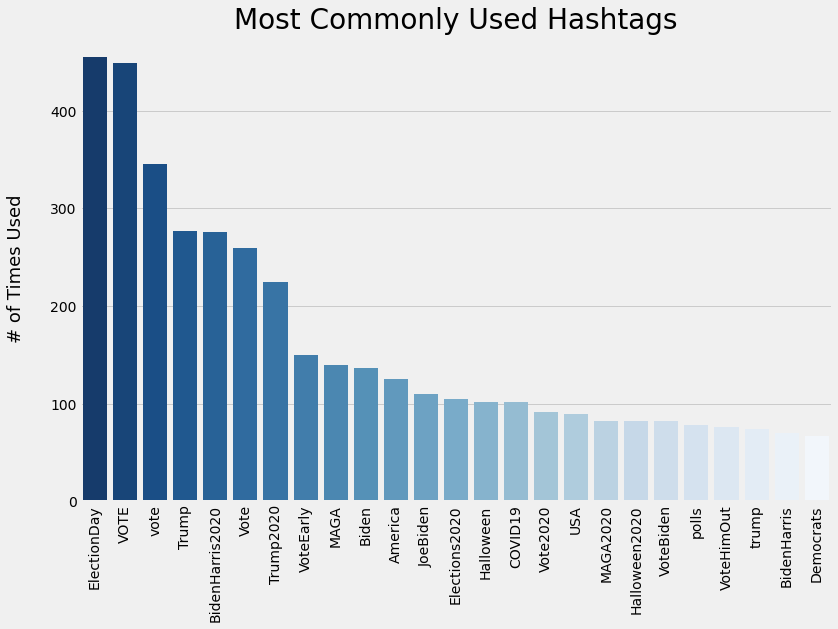

In [203]:
fig, ax = plt.subplots(figsize = (12, 8))

sns.barplot(x = top_keys, y = top_values, palette=("Blues_r"))

ax.set_title("Most Commonly Used Hashtags")
ax.set_xticklabels(top_keys, rotation = 90)
ax.set_ylabel("# of Times Used", labelpad = 25);

## Tweets by Location

In [204]:
df['user_location'].loc[df['user_location'].notnull()]

1              Las Vegas, NV
2                   New York
3             Bemidji, Minn.
5       Dublin city, Ireland
6       S A N    F R A N  !!
                ...         
9994              Patten, ME
9995           United States
9996              Sonoma, CA
9998              Boston, MA
9999             Roxbury, NJ
Name: user_location, Length: 7778, dtype: object

In [205]:
state_abbrevs = [
    'AL', 'AK', 'AR', 'AZ', 'CA', 'CO', 'CT', 'DC', 'DE', 'FL', 'GA', 'HI', 'IA', 'ID', 'IL', 'IN', 'KS', 'KY', 
    'LA', 'MA', 'MD', 'ME', 'MI', 'MN', 'MO', 'MS', 'MT', 'NC', 'ND', 'NE', 'NH', 'NJ', 'NM', 'NV', 'NY', 'OH',
    'OK', 'OR', 'PA', 'RI', 'SC', 'SD', 'TN', 'TX', 'UT', 'VA', 'VT', 'WA', 'WI', 'WV', 'WY'
]

In [206]:
states = [
    'Alabama', 'Alaska', 'Arkansas', 'Arizona', 'California', 'Colorado', 'Connecticut', 'District of Columbia', 
    'Delaware', 'Florida', 'Georgia', 'Hawaii', 'Iowa', 'Idaho', 'Illinois', 'Indiana', 'Kansas', 'Kentucky', 
    'Louisiana', 'Massachusetts', 'Maryland', 'Maine', 'Michigan', 'Minnesota', 'Missouri', 'Mississippi', 
    'Montana', 'North Carolina', 'North Dakota', 'Nebraska', 'New Hampshire', 'New Jersey', 'New Mexico', 'Nevada', 
    'New York', 'Ohio', 'Oklahoma', 'Oregon', 'Pennsylvania', 'Rhode Island', 'South Carolina', 'South Dakota', 
    'Tennessee', 'Texas', 'Utah', 'Virginia', 'Vermont', 'Washington', 'Wisconsin', 'West Virginia', 'Wyoming'
]

In [207]:
len(state_abbrevs)    # 51 because we included DC

51

In [208]:
# Given string of a user's location, finds if there is an applicable state we can assign
def find_state(loc):
    if str(loc) == 'nan':
        return np.nan
    else:
        match = re.match(r'^\w+\s?\w+,\s{1}[A-Z]{2}', loc)
        if match is None:
            return np.nan
        elif match.group()[-2:] in state_abbrevs: 
            return match.group()[-2:]
        else:
            return np.nan     

In [209]:
df['user_state'] = df['user_location'].apply(lambda x: find_state(x))

In [210]:
df['user_state'].isnull().sum()

7253

In [211]:
df['user_state'] = df['user_state'].map(dict(zip(state_abbrevs, states)))

Most of the states do not have a state we can assign to them.

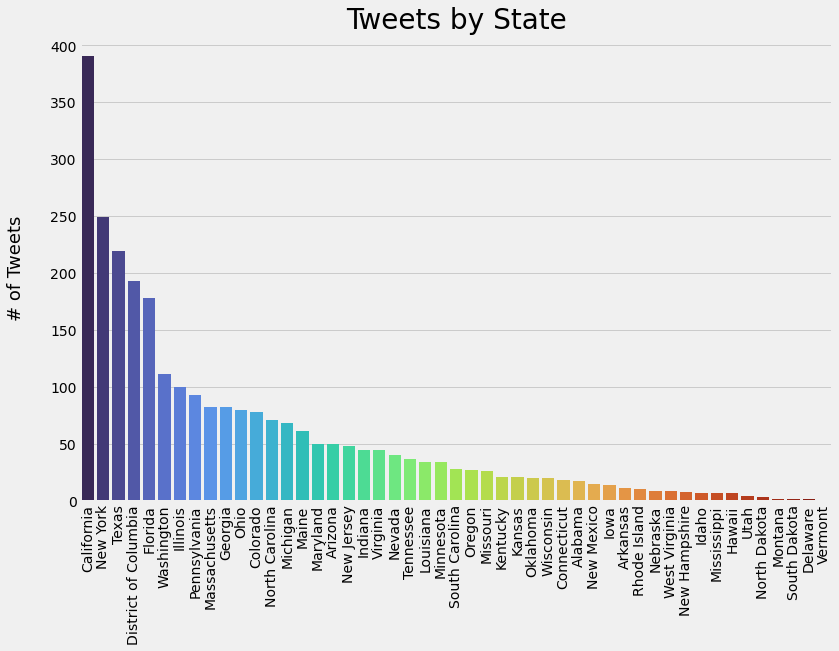

In [212]:
state_counts = df['user_state'].value_counts()

fig, ax = plt.subplots(figsize = (12, 8))

sns.barplot(x = state_counts.index, y = state_counts, palette=("turbo"))
ax.set_title("Tweets by State")
ax.set_xticklabels(state_counts.index, rotation = 90)
ax.set_ylabel("# of Tweets", labelpad = 25);

# Text Cleaning + Preprocessing

## Drop Other Columns

For simplicity, let's just get the text of the tweets to work with:

In [213]:
text_df = pd.DataFrame(df['text'])
text_df.head()

,text
0,"During this election time, let us pray for the nation and wisely choose our leaders.\n#Election2..."
1,"This year, Nevada could eclipse the overall turnout in the 2016 general election — a little more..."
2,"🗳️ Friendly reminder that early voting ends TOMORROW, November 1! \n\nVote early TODAY to help e..."
3,Why I Vote ✔️\n\n@BSUBeaverSoccer's Alyssa Stumbaugh tells us why she votes\n\n#BeaverTerritory ...
4,Be sure to listen to this weeks #podcast where I recap the final Presidential #Debates2020 and l...


## Remove Noise from Text

Let's first remove any URLs, mentions (e.g., @realDonaldTrump), and emojis in the tweets, since these add a lot of noise to the data. We'll use the tweet preprocessing library for this.

In [214]:
for i, tweet in enumerate(text_df['text']):
    text_df.loc[i, 'text'] = p.clean(tweet)

Next, we must get rid of a few different things:
- uppercase letters
- punctuation
- numerical digits

In [215]:
# Make all characters lowercase and remove numbers + punctuation
def remove_noise(text):
    text_lc = ''.join([word.lower() for word in text if word not in string.punctuation])
    text = re.sub(r'\d+', '', text_lc)
    return text

In [216]:
text_df['text_cleaned'] = text_df['text'].apply(lambda x: remove_noise(x))

In [217]:
text_df.head()

,text,text_cleaned
0,"During this election time, let us pray for the nation and wisely choose our leaders.",during this election time let us pray for the nation and wisely choose our leaders
1,"This year, Nevada could eclipse the overall turnout in the general election a little more than m...",this year nevada could eclipse the overall turnout in the general election a little more than mi...
2,"Friendly reminder that early voting ends TOMORROW, November ! Vote early TODAY to help ensure di...",friendly reminder that early voting ends tomorrow november vote early today to help ensure dign...
3,Why I Vote 's Alyssa Stumbaugh tells us why she votes,why i vote s alyssa stumbaugh tells us why she votes
4,Be sure to listen to this weeks where I recap the final Presidential and look forward to the,be sure to listen to this weeks where i recap the final presidential and look forward to the


## Tokenization

Tokenization refers to breaking a block/string of continuous text into a list of all of the words that appear in the string.

In [218]:
def tokenize(text):
    return re.split('\W+', text)

In [219]:
text_df['text_tokenized'] = text_df['text'].apply(lambda x: tokenize(remove_noise(x)))

We now have a new column in the text_df data frame, which contains an updated version of the text, converted to all lowercase with the numbers + punctuation taken out, then converted to a list of tokens, or words from the text.

In [220]:
text_df.head()

,text,text_cleaned,text_tokenized
0,"During this election time, let us pray for the nation and wisely choose our leaders.",during this election time let us pray for the nation and wisely choose our leaders,"[during, this, election, time, let, us, pray, for, the, nation, and, wisely, choose, our, leaders]"
1,"This year, Nevada could eclipse the overall turnout in the general election a little more than m...",this year nevada could eclipse the overall turnout in the general election a little more than mi...,"[this, year, nevada, could, eclipse, the, overall, turnout, in, the, general, election, a, littl..."
2,"Friendly reminder that early voting ends TOMORROW, November ! Vote early TODAY to help ensure di...",friendly reminder that early voting ends tomorrow november vote early today to help ensure dign...,"[friendly, reminder, that, early, voting, ends, tomorrow, november, vote, early, today, to, help..."
3,Why I Vote 's Alyssa Stumbaugh tells us why she votes,why i vote s alyssa stumbaugh tells us why she votes,"[why, i, vote, s, alyssa, stumbaugh, tells, us, why, she, votes]"
4,Be sure to listen to this weeks where I recap the final Presidential and look forward to the,be sure to listen to this weeks where i recap the final presidential and look forward to the,"[be, sure, to, listen, to, this, weeks, where, i, recap, the, final, presidential, and, look, fo..."


## Remove Stopwords

Stopwords are very commonly used words such as "the", "in", "a", etc. that we want to exclude from our later analysis, so that they don't take up any unnecessary space and/or processing time. Now that we have tokenized the text, we can search for any stopwords and take them out. 

In [221]:
stop_words = set(stopwords.words('english'))
stop_words.update(['im', 'let', 'us'])    # Add some other words I've noticed are not very relevant

In [222]:
def remove_stopwords(text):    
    text_no_stopwords = [word for word in text if word not in stop_words]
    return text_no_stopwords

In [223]:
text_df['text_no_stopwords'] = text_df['text_tokenized'].apply(lambda x: remove_stopwords(x))

In [224]:
text_df.head()

,text,text_cleaned,text_tokenized,text_no_stopwords
0,"During this election time, let us pray for the nation and wisely choose our leaders.",during this election time let us pray for the nation and wisely choose our leaders,"[during, this, election, time, let, us, pray, for, the, nation, and, wisely, choose, our, leaders]","[election, time, pray, nation, wisely, choose, leaders]"
1,"This year, Nevada could eclipse the overall turnout in the general election a little more than m...",this year nevada could eclipse the overall turnout in the general election a little more than mi...,"[this, year, nevada, could, eclipse, the, overall, turnout, in, the, general, election, a, littl...","[year, nevada, could, eclipse, overall, turnout, general, election, little, million, polls, open..."
2,"Friendly reminder that early voting ends TOMORROW, November ! Vote early TODAY to help ensure di...",friendly reminder that early voting ends tomorrow november vote early today to help ensure dign...,"[friendly, reminder, that, early, voting, ends, tomorrow, november, vote, early, today, to, help...","[friendly, reminder, early, voting, ends, tomorrow, november, vote, early, today, help, ensure, ..."
3,Why I Vote 's Alyssa Stumbaugh tells us why she votes,why i vote s alyssa stumbaugh tells us why she votes,"[why, i, vote, s, alyssa, stumbaugh, tells, us, why, she, votes]","[vote, alyssa, stumbaugh, tells, votes]"
4,Be sure to listen to this weeks where I recap the final Presidential and look forward to the,be sure to listen to this weeks where i recap the final presidential and look forward to the,"[be, sure, to, listen, to, this, weeks, where, i, recap, the, final, presidential, and, look, fo...","[sure, listen, weeks, recap, final, presidential, look, forward]"


## Stemming

TO DO: add explanation of stemming here!

In [225]:
stemmer = nltk.PorterStemmer()

def stem(text):
    return [stemmer.stem(word) for word in text]

In [226]:
text_df['text_stemmed'] = text_df['text_no_stopwords'].apply(lambda x: stem(x))

In [227]:
text_df.head()

,text,text_cleaned,text_tokenized,text_no_stopwords,text_stemmed
0,"During this election time, let us pray for the nation and wisely choose our leaders.",during this election time let us pray for the nation and wisely choose our leaders,"[during, this, election, time, let, us, pray, for, the, nation, and, wisely, choose, our, leaders]","[election, time, pray, nation, wisely, choose, leaders]","[elect, time, pray, nation, wise, choos, leader]"
1,"This year, Nevada could eclipse the overall turnout in the general election a little more than m...",this year nevada could eclipse the overall turnout in the general election a little more than mi...,"[this, year, nevada, could, eclipse, the, overall, turnout, in, the, general, election, a, littl...","[year, nevada, could, eclipse, overall, turnout, general, election, little, million, polls, open...","[year, nevada, could, eclips, overal, turnout, gener, elect, littl, million, poll, open, elect, ..."
2,"Friendly reminder that early voting ends TOMORROW, November ! Vote early TODAY to help ensure di...",friendly reminder that early voting ends tomorrow november vote early today to help ensure dign...,"[friendly, reminder, that, early, voting, ends, tomorrow, november, vote, early, today, to, help...","[friendly, reminder, early, voting, ends, tomorrow, november, vote, early, today, help, ensure, ...","[friendli, remind, earli, vote, end, tomorrow, novemb, vote, earli, today, help, ensur, digniti,..."
3,Why I Vote 's Alyssa Stumbaugh tells us why she votes,why i vote s alyssa stumbaugh tells us why she votes,"[why, i, vote, s, alyssa, stumbaugh, tells, us, why, she, votes]","[vote, alyssa, stumbaugh, tells, votes]","[vote, alyssa, stumbaugh, tell, vote]"
4,Be sure to listen to this weeks where I recap the final Presidential and look forward to the,be sure to listen to this weeks where i recap the final presidential and look forward to the,"[be, sure, to, listen, to, this, weeks, where, i, recap, the, final, presidential, and, look, fo...","[sure, listen, weeks, recap, final, presidential, look, forward]","[sure, listen, week, recap, final, presidenti, look, forward]"


## Lemmatization

TO DO: add explanation of lemmatization here!

In [228]:
lemmatizer = nltk.WordNetLemmatizer()

def lemmatize(text):
    return [lemmatizer.lemmatize(word) for word in text]

We now have another new column, this one representing the lemmatized text

In [229]:
text_df['text_lemmatized'] = text_df['text_no_stopwords'].apply(lambda x: lemmatize(x))

Let's take a look at our final, fully preprocessed text

In [230]:
text_df.head()

,text,text_cleaned,text_tokenized,text_no_stopwords,text_stemmed,text_lemmatized
0,"During this election time, let us pray for the nation and wisely choose our leaders.",during this election time let us pray for the nation and wisely choose our leaders,"[during, this, election, time, let, us, pray, for, the, nation, and, wisely, choose, our, leaders]","[election, time, pray, nation, wisely, choose, leaders]","[elect, time, pray, nation, wise, choos, leader]","[election, time, pray, nation, wisely, choose, leader]"
1,"This year, Nevada could eclipse the overall turnout in the general election a little more than m...",this year nevada could eclipse the overall turnout in the general election a little more than mi...,"[this, year, nevada, could, eclipse, the, overall, turnout, in, the, general, election, a, littl...","[year, nevada, could, eclipse, overall, turnout, general, election, little, million, polls, open...","[year, nevada, could, eclips, overal, turnout, gener, elect, littl, million, poll, open, elect, ...","[year, nevada, could, eclipse, overall, turnout, general, election, little, million, poll, open,..."
2,"Friendly reminder that early voting ends TOMORROW, November ! Vote early TODAY to help ensure di...",friendly reminder that early voting ends tomorrow november vote early today to help ensure dign...,"[friendly, reminder, that, early, voting, ends, tomorrow, november, vote, early, today, to, help...","[friendly, reminder, early, voting, ends, tomorrow, november, vote, early, today, help, ensure, ...","[friendli, remind, earli, vote, end, tomorrow, novemb, vote, earli, today, help, ensur, digniti,...","[friendly, reminder, early, voting, end, tomorrow, november, vote, early, today, help, ensure, d..."
3,Why I Vote 's Alyssa Stumbaugh tells us why she votes,why i vote s alyssa stumbaugh tells us why she votes,"[why, i, vote, s, alyssa, stumbaugh, tells, us, why, she, votes]","[vote, alyssa, stumbaugh, tells, votes]","[vote, alyssa, stumbaugh, tell, vote]","[vote, alyssa, stumbaugh, tell, vote]"
4,Be sure to listen to this weeks where I recap the final Presidential and look forward to the,be sure to listen to this weeks where i recap the final presidential and look forward to the,"[be, sure, to, listen, to, this, weeks, where, i, recap, the, final, presidential, and, look, fo...","[sure, listen, weeks, recap, final, presidential, look, forward]","[sure, listen, week, recap, final, presidenti, look, forward]","[sure, listen, week, recap, final, presidential, look, forward]"


Now, we can add the new, lemmatized text as well as our cleaned text (before tokenization, etc.) back to our original dataframe.

In [231]:
df['text_cleaned'] = text_df['text_cleaned']
df['text_lemmatized'] = text_df['text_lemmatized']

In [232]:
df.head()

,tweet_id,created_at,text,hashtags,retweets_count,favorites_count,user_id,user_name,user_screen_name,user_desc,...,created_at_hour,num_tweets,num_retweets,num_favorites,user_state,text_cleaned,text_lemmatized,biden,trump,polarity
0,1322659618837975045,2020-10-31 22:00:01,"During this election time, let us pray for the nation and wisely choose our leaders.\n#Election2...","['Election2020', 'USElection2020', 'Vote', 'Prayer', 'Trust', 'Prayer']",0,0,971218837,Shalom World,ShalomWorldTV,GOD'S OWN CHANNEL,...,22,"1,000 to 10,000",None,None,NaN,during this election time let us pray for the nation and wisely choose our leaders,"[election, time, pray, nation, wisely, choose, leader]",False,False,0.70000
1,1322659616552079361,2020-10-31 22:00:01,"This year, Nevada could eclipse the overall turnout in the 2016 general election — a little more...",['Election2020'],0,0,15358759,Las Vegas Review-Journal,reviewjournal,Nevada's largest newspaper and the most reliable source for news in Las Vegas. Send news tips to...,...,22,"More than 100,000",None,None,Nevada,this year nevada could eclipse the overall turnout in the general election a little more than mi...,"[year, nevada, could, eclipse, overall, turnout, general, election, little, million, poll, open,...",False,False,0.07250
2,1322659615860019200,2020-10-31 22:00:00,"🗳️ Friendly reminder that early voting ends TOMORROW, November 1! \n\nVote early TODAY to help e...",['Election2020'],0,0,551520612,Make the Road Action 🦋,MaketheRoadAct,"Building power, promoting policy solutions, & strengthening the movement for justice for immigra...",...,22,"10,000 to 100,000",None,None,NaN,friendly reminder that early voting ends tomorrow november vote early today to help ensure dign...,"[friendly, reminder, early, voting, end, tomorrow, november, vote, early, today, help, ensure, d...",False,False,0.16875
3,1322659614492516353,2020-10-31 22:00:00,Why I Vote ✔️\n\n@BSUBeaverSoccer's Alyssa Stumbaugh tells us why she votes\n\n#BeaverTerritory ...,"['BeaverTerritory', 'Election2020']",0,0,25717467,Bemidji St. Beavers,BSUBeavers,"The latest news, scores and upcoming Beaver Athletics events from the Bemidji State Office of At...",...,22,"10,000 to 100,000",None,None,NaN,why i vote s alyssa stumbaugh tells us why she votes,"[vote, alyssa, stumbaugh, tell, vote]",False,False,0.00000
4,1322659614282842113,2020-10-31 22:00:00,Be sure to listen to this weeks #podcast where I recap the final Presidential #Debates2020 and l...,"['podcast', 'Debates2020', 'ElectionDay', 'Debates2020', 'Debate2020', 'Election2020', 'Election...",0,0,833726321381498882,The Statecraft Observer Podcast † 🇺🇸 🎙️,StatecraftTweet,Brandon D. Keller: I am a conservative political commentator/writer.\n\nHost of The STATECRAFT ...,...,22,"1,000 to 10,000",None,None,NaN,be sure to listen to this weeks where i recap the final presidential and look forward to the,"[sure, listen, week, recap, final, presidential, look, forward]",False,False,0.25000


## Vectorization

In [233]:
# Function we will use when vectorizing; covers all previous cleaning steps (except lemmatization)
def preprocess_text(text):
    text_lc = ''.join([word.lower() for word in text if word not in string.punctuation]) # make lowercase and remove puntuation
    text_rc = re.sub(r'\d+', '', text_lc)
    tokens = re.split('\W+', text_rc)    # tokenization
    text_cleaned = [stemmer.stem(word) for word in tokens if word not in stop_words]  # remove stopwords and stemming
    return text_cleaned

In [234]:
countVectorizer = CountVectorizer(analyzer = preprocess_text) 
text_vectorized = countVectorizer.fit_transform(df['text'])
print("There are {} tweets with {} words".format(text_vectorized.shape[0], text_vectorized.shape[1]))

There are 10000 tweets with 19983 words


In [235]:
# Dataframe of vectorized text
vectorized_df = pd.DataFrame(text_vectorized.toarray(), columns = countVectorizer.get_feature_names())
vectorized_df.head()

,,aaaaaahahhaaha,aaaaah,aamirbaqir,aan,aapi,aapivot,aapl,aapor,aaron,...,களத,ங,ச,ட,த,மக,ய,ர,வ,시간
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Most Common Words

Now, let's try to compile the most common words used in our tweets.

In [236]:
list_of_words = df['text_lemmatized'].tolist()
all_words = [word for sublist in list_of_words for word in sublist]

In [237]:
#Frequency of words
fdist = FreqDist(all_words)
fdist

FreqDist({'voting': 10232, 'vote': 6177, 'ballot': 5156, 'make': 5114, 'plan': 5019, 'matter': 4983, 'polling': 4935, 'drop': 4931, 'place': 4925, 'site': 4904, ...})

In [238]:
words_dict = {k: v for k, v in sorted(dict(fdist).items(), key=lambda item: item[1], reverse = True)}
words_dict

{'voting': 10232,
 'vote': 6177,
 'ballot': 5156,
 'make': 5114,
 'plan': 5019,
 'matter': 4983,
 'polling': 4935,
 'drop': 4931,
 'place': 4925,
 'site': 4904,
 'box': 4897,
 'finding': 4879,
 'instruction': 4862,
 'trump': 868,
 '': 819,
 'election': 682,
 'day': 500,
 'biden': 434,
 'amp': 412,
 'voter': 320,
 'people': 312,
 'like': 307,
 'one': 292,
 'get': 285,
 'dont': 282,
 'right': 249,
 'today': 242,
 'win': 242,
 'poll': 239,
 'president': 224,
 'state': 224,
 'early': 215,
 'time': 212,
 'go': 206,
 'year': 197,
 'american': 196,
 'voted': 178,
 'know': 178,
 'need': 176,
 'america': 176,
 'line': 171,
 'new': 163,
 'say': 157,
 'going': 156,
 'rally': 149,
 'tuesday': 146,
 'many': 146,
 'want': 145,
 'joe': 141,
 'every': 135,
 'would': 132,
 'help': 128,
 'take': 127,
 'county': 127,
 'via': 126,
 'see': 125,
 'country': 121,
 'think': 120,
 'campaign': 120,
 'please': 119,
 'person': 117,
 'great': 117,
 'must': 117,
 'sure': 116,
 'first': 110,
 'last': 110,
 'still': 

In [239]:
top_keys = list(words_dict)[:50]
top_values = [words_dict[key] for key in list(words_dict)[:50]]

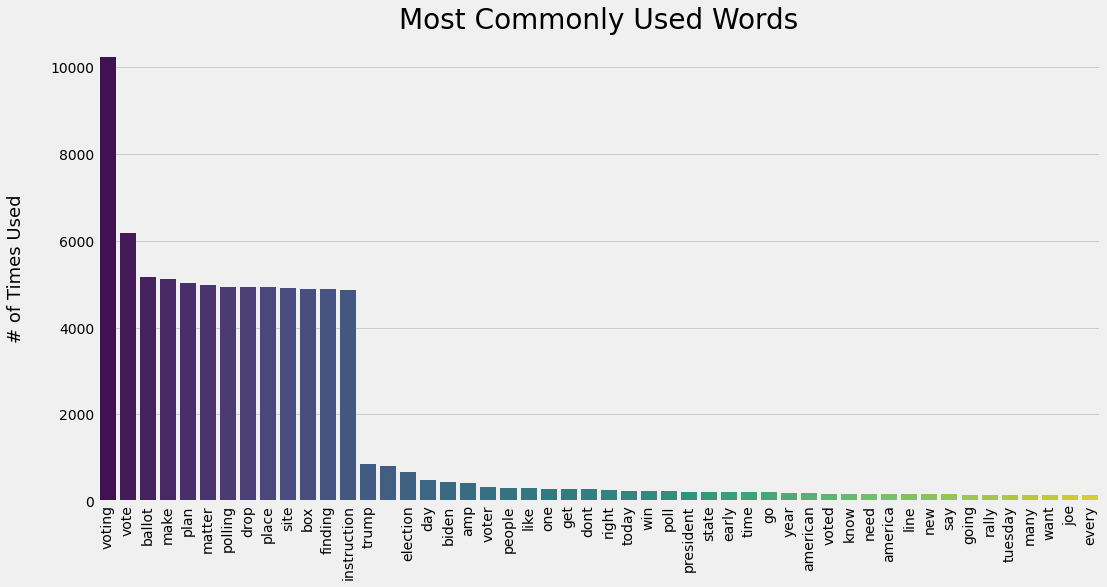

In [240]:
fig, ax = plt.subplots(figsize = (16, 8))

ax = sns.barplot(x = top_keys, y = top_values, palette = 'viridis')

ax.set_title("Most Commonly Used Words")
ax.set_xticklabels(top_keys, rotation = 90)
ax.set_ylabel("# of Times Used", labelpad = 25);

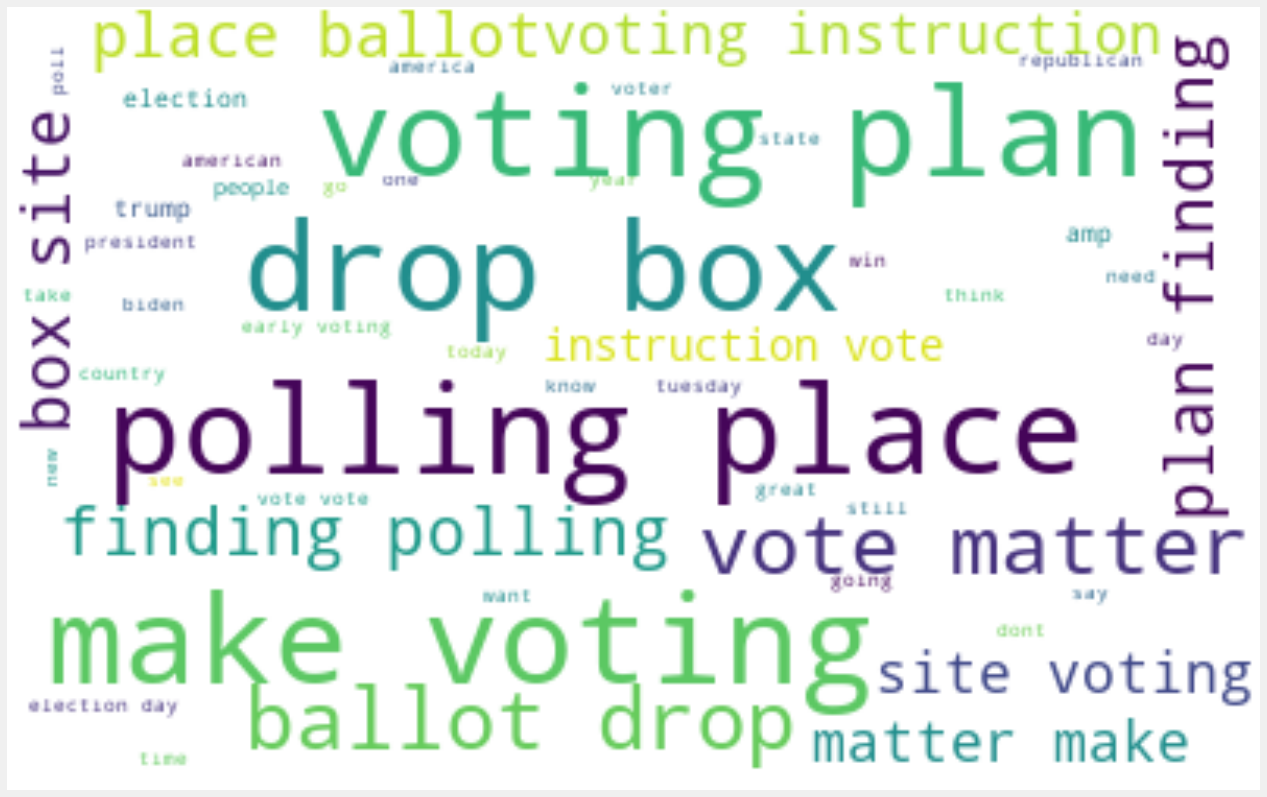

In [252]:
fig, ax = plt.subplots(figsize = (20, 20))

# Create and generate a word cloud image:
text = " ".join(word for word in all_words)

wordcloud = WordCloud(max_font_size = 40, max_words = 50, background_color = "white", width = 400, height = 250).generate(text)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

Unsurprisingly, "Biden" and "Trump" appear to two realatively common words in our tweets. Now let's look at mentions of Biden vs. mentions of Trump across different states.

## "Biden" vs. "Trump"

In [253]:
df['biden'] = df['text_lemmatized'].apply(lambda x: "biden" in x)
print('{} tweets contain "biden"'.format(sum(df['biden'])))

389 tweets contain "biden"


In [254]:
df['trump'] = df['text_lemmatized'].apply(lambda x: "trump" in x)
print('{} tweets contain "trump"'.format(sum(df['trump'])))

754 tweets contain "trump"


In [255]:
biden_by_state = df.groupby('user_state')['biden'].apply(sum).sort_values()
# biden_by_state    # Divide by total tweets for each state to get a proportion? More accurate this way?

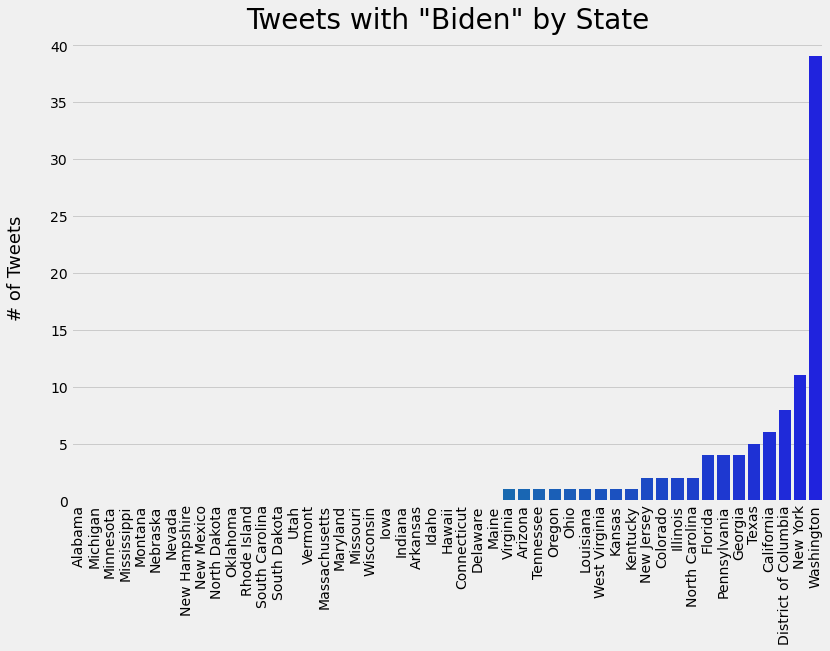

In [256]:
biden_by_state = df.groupby('user_state')['biden'].apply(sum).sort_values()

fig, ax = plt.subplots(figsize = (12, 8))

sns.barplot(x = biden_by_state.index, y = biden_by_state, palette=("winter_r"))
ax.set_title('Tweets with "Biden" by State')
ax.set_xticklabels(biden_by_state.index, rotation = 90)
ax.set_xlabel("")
ax.set_ylabel("# of Tweets", labelpad = 25);

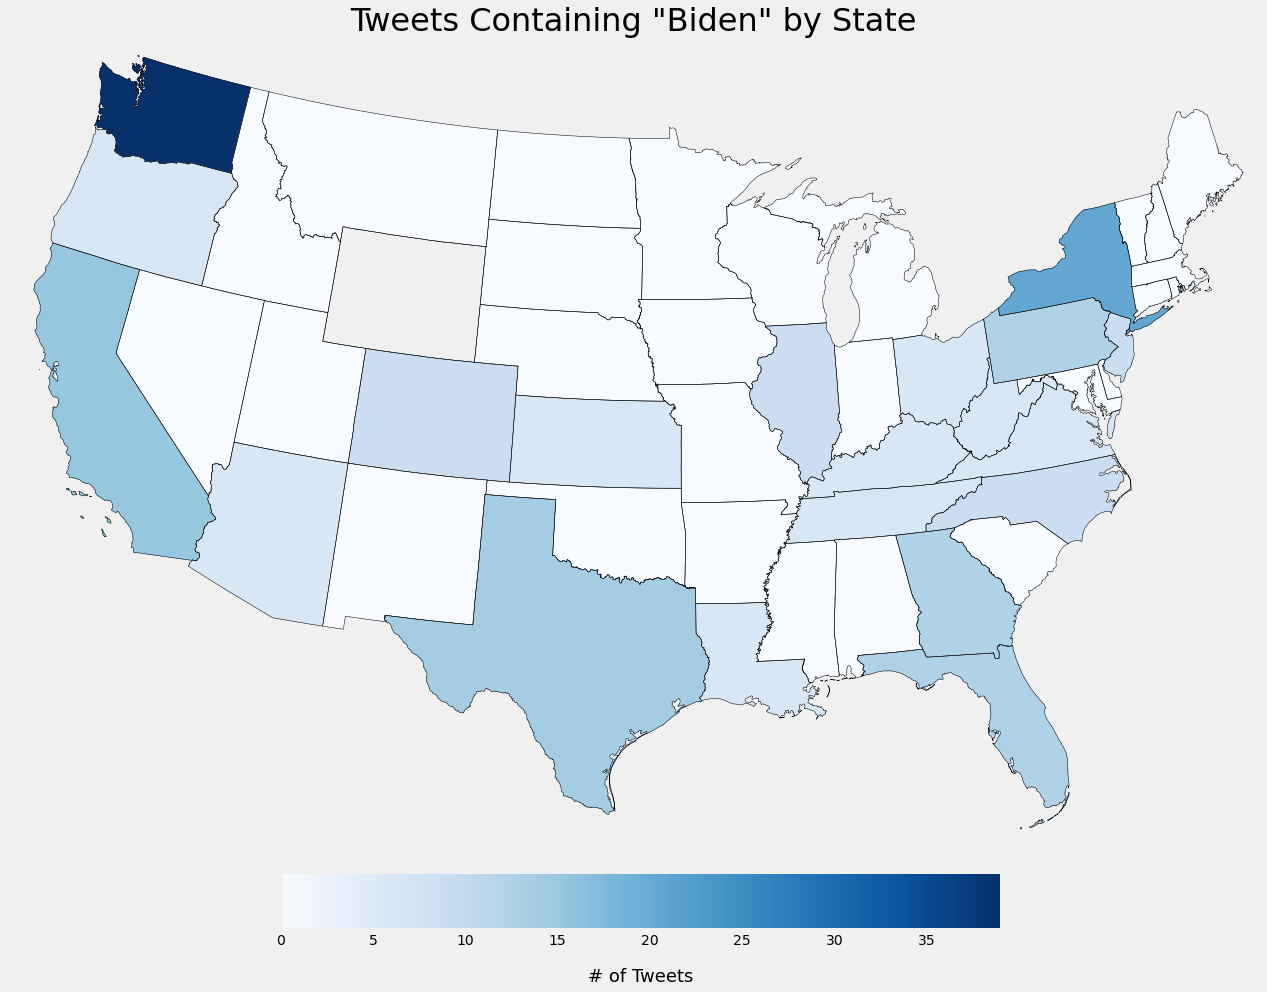

In [267]:
biden_dict = dict(biden_by_state)

plt.subplots(figsize = (20, 16))
plt.title('Tweets Containing "Biden" by State', fontsize = 32)

# Create map
m = Basemap(llcrnrlon=-119,llcrnrlat=22,urcrnrlon=-64,urcrnrlat=49,
        projection='lcc',lat_1=33,lat_2=45,lon_0=-95)
ax = plt.gca() 
fig = plt.gcf()

# load the shapefile, use the name 'states'
m.readshapefile('../st99_d00', name='states', drawbounds=True)

# choose a color for each state based on population density.
colors={}
statenames=[]
cmap = plt.cm.Blues
patches = []
vmin = min(biden_dict.values()); vmax = max(biden_dict.values())
norm = Normalize(vmin=vmin, vmax=vmax)
# color mapper to covert values to colors
mapper = ScalarMappable(norm=norm, cmap=cmap)

for shapedict in m.states_info:
    statename = shapedict['NAME']
    # skip DC and Puerto Rico.
    if statename not in ['District of Columbia','Puerto Rico', 'Alaska', 'Wyoming']:
        pop = biden_dict[statename]
        # calling colormap with value between 0 and 1 returns
        # rgba value.  Invert color range (hot colors are high
        # population), take sqrt root to spread out colors more.
        colors[statename] = cmap(np.sqrt((pop-vmin)/(vmax-vmin)))[:3]
    statenames.append(statename)
    
# cycle through state names, color each one.
for nshape,seg in enumerate(m.states):
    # skip DC and Puerto Rico.
    if statenames[nshape] not in ['District of Columbia','Puerto Rico', 'Alaska', 'Wyoming']:
#     # Offset Alaska and Hawaii to the lower-left corner. 
#         if statenames[nshape] == 'Alaska':
#         # Alaska is too big. Scale it down to 35% first, then transate it. 
#             seg = list(map(lambda x, y: (0.35*x + 1100000, 0.35*y-1300000), seg))
#         if statenames[nshape] == 'Hawaii':
#             seg = list(map(lambda x, y: (x + 5100000, y-900000), seg))

        color = rgb2hex(colors[statenames[nshape]]) 
        poly = Polygon(seg,facecolor=color,edgecolor=color)
        ax.add_patch(poly)
    else:
        pass
      
# Construct colorbar
cax = fig.add_axes([0.27, 0.05, 0.5, 0.05]) # Create new axes for colorbar for positioning purposes
cb = ColorbarBase(cax,cmap = cmap,norm = norm, orientation = 'horizontal')
cb.ax.set_xlabel('# of Tweets', labelpad = 20)

plt.show();

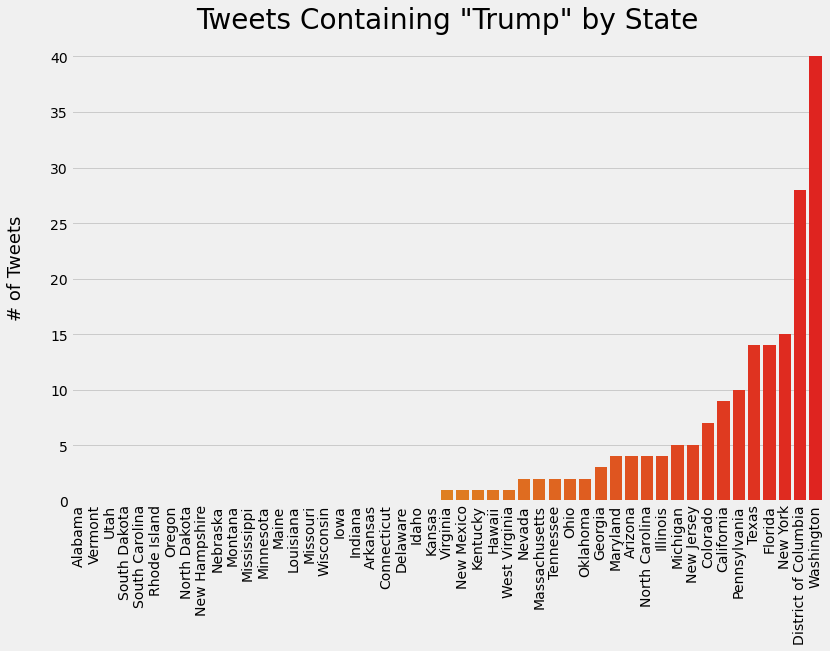

In [264]:
trump_by_state = df.groupby('user_state')['trump'].apply(sum).sort_values()

fig, ax = plt.subplots(figsize = (12, 8))

sns.barplot(x = trump_by_state.index, y = trump_by_state, palette=("autumn_r"))
ax.set_title('Tweets Containing "Trump" by State')
ax.set_xticklabels(trump_by_state.index, rotation = 90)
ax.set_xlabel("")
ax.set_ylabel("# of Tweets", labelpad = 25);

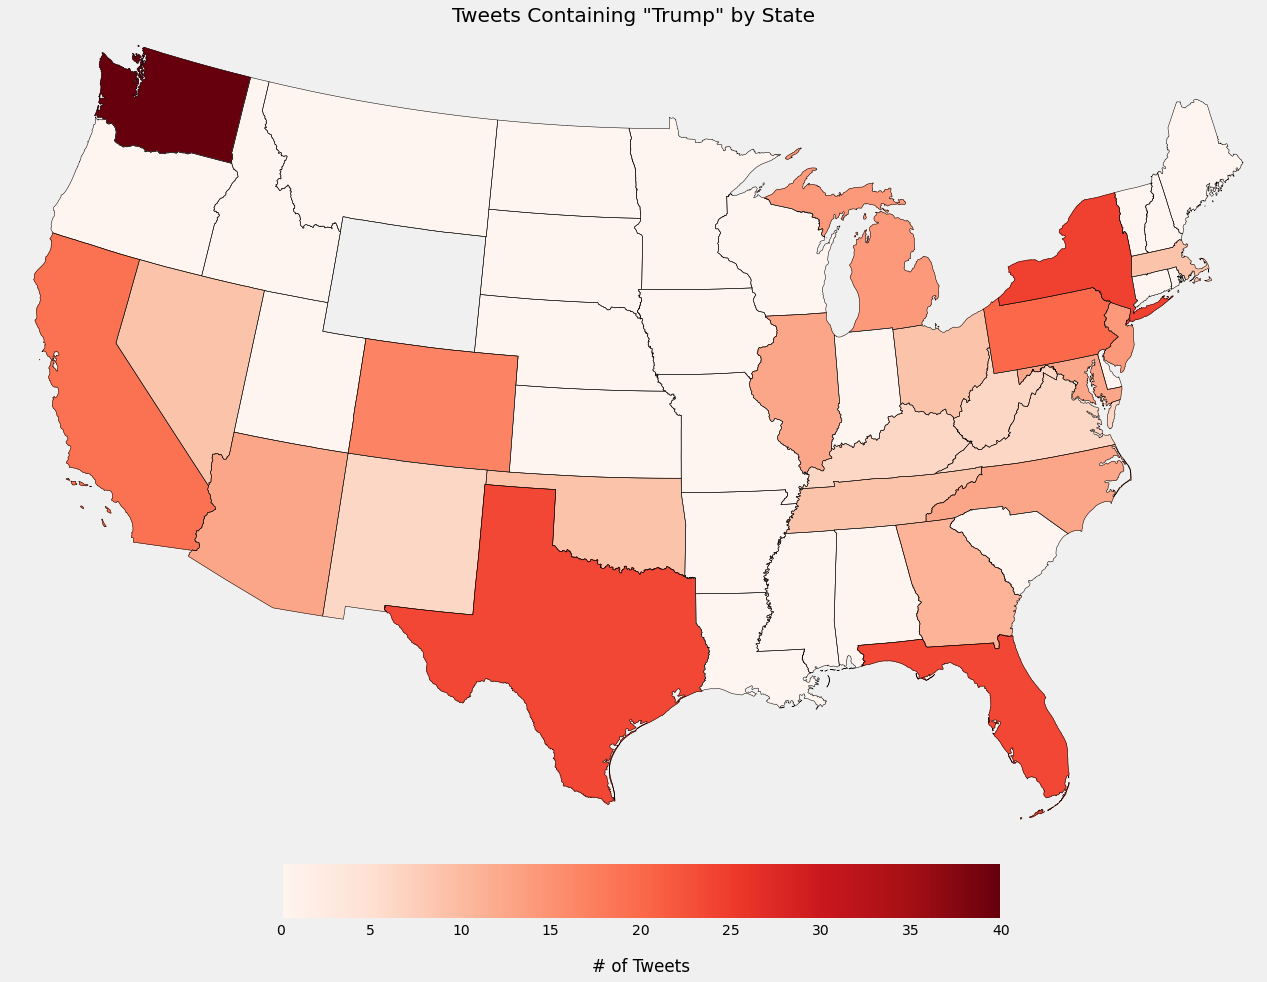

In [166]:
trump_dict = dict(trump_by_state)

plt.subplots(figsize = (20, 16))
plt.title('Tweets Containing "Trump" by State', fontsize = 32)

# Create map
m = Basemap(llcrnrlon=-119,llcrnrlat=22,urcrnrlon=-64,urcrnrlat=49,
        projection='lcc',lat_1=33,lat_2=45,lon_0=-95)
ax = plt.gca() 
fig = plt.gcf()

# load the shapefile, use the name 'states'
m.readshapefile('../st99_d00', name='states', drawbounds=True)

# choose a color for each state based on population density.
colors={}
statenames=[]
cmap = plt.cm.Reds
patches = []
vmin = min(trump_dict.values()); vmax = max(trump_dict.values())
norm = Normalize(vmin=vmin, vmax=vmax)
# color mapper to covert values to colors
mapper = ScalarMappable(norm=norm, cmap=cmap)

for shapedict in m.states_info:
    statename = shapedict['NAME']
    # skip DC and Puerto Rico.
    if statename not in ['District of Columbia','Puerto Rico', 'Alaska', 'Wyoming']:
        pop = trump_dict[statename]
        # calling colormap with value between 0 and 1 returns
        # rgba value.  Invert color range (hot colors are high
        # population), take sqrt root to spread out colors more.
        colors[statename] = cmap(np.sqrt((pop-vmin)/(vmax-vmin)))[:3]
    statenames.append(statename)
    
# cycle through state names, color each one.
for nshape,seg in enumerate(m.states):
    # skip DC and Puerto Rico.
    if statenames[nshape] not in ['District of Columbia','Puerto Rico', 'Alaska', 'Wyoming']:
#     # Offset Alaska and Hawaii to the lower-left corner. 
#         if statenames[nshape] == 'Alaska':
#         # Alaska is too big. Scale it down to 35% first, then transate it. 
#             seg = list(map(lambda x, y: (0.35*x + 1100000, 0.35*y-1300000), seg))
#         if statenames[nshape] == 'Hawaii':
#             seg = list(map(lambda x, y: (x + 5100000, y-900000), seg))

        color = rgb2hex(colors[statenames[nshape]]) 
        poly = Polygon(seg,facecolor=color,edgecolor=color)
        ax.add_patch(poly)
    else:
        pass
      
    
plt.title('Tweets Containing "Trump" by State')

# Construct colorbar
cax = fig.add_axes([0.27, 0.05, 0.5, 0.05]) # Create new axes for colorbar for positioning purposes
cb = ColorbarBase(cax,cmap = cmap,norm = norm, orientation = 'horizontal')
cb.ax.set_xlabel('# of Tweets', labelpad = 20)

plt.show();

# Sentiment Analysis

We've looked at a ton of different patterns so far, and even looked a bit into the tweets' text. Finally, time to look closer at the text content of the tweets and perform sentiment analysis on them so that we get a better idea of what they're actually saying, rather than just a glimpse at some words they contain. Let's attempt to see what the users were feeling when they posted these tweets.

For each tweet, we will find its "polarity" score (i.e., the overall sentiment score):
- The closer to 1, the more positive
- The closer to -1, the more negative
- 0 denotes neutrality

In [167]:
def find_polarity(tweet):
    return TextBlob(tweet).sentiment.polarity

In [170]:
df['polarity'] = df['text_cleaned'].apply(lambda x: find_polarity(x))

In [171]:
df[['text_cleaned', 'polarity']].head()

,text_cleaned,polarity
0,during this election time let us pray for the nation and wisely choose our leaders,0.70000
1,this year nevada could eclipse the overall turnout in the general election a little more than mi...,0.07250
2,friendly reminder that early voting ends tomorrow november vote early today to help ensure dign...,0.16875
3,why i vote s alyssa stumbaugh tells us why she votes,0.00000
4,be sure to listen to this weeks where i recap the final presidential and look forward to the,0.25000


Let's now create a new dataframe for each presidential candidate to aid our exploration of how each was talked about by Twitter users during the election.

In [172]:
biden_df = df.loc[df['biden']]
biden_df.shape

(389, 24)

In [173]:
trump_df = df.loc[df['trump']]
trump_df.shape

(754, 24)

In [174]:
biden_polarity = biden_df.groupby('user_state')['polarity'].apply(np.mean)
biden_polarity

user_state
Arizona                 0.000000
California              0.170489
Colorado               -0.072917
District of Columbia    0.078224
Florida                 0.094792
Georgia                -0.104167
Illinois               -0.272917
Kansas                  0.193333
Kentucky                0.000000
Louisiana              -0.500000
New Jersey              0.318182
New York               -0.000192
North Carolina          0.178125
Ohio                    0.000000
Oregon                  0.125000
Pennsylvania            0.100000
Tennessee               0.200000
Texas                   0.135636
Virginia                0.046429
Washington              0.194619
West Virginia           0.400000
Name: polarity, dtype: float64

In [175]:
trump_polarity = trump_df.groupby('user_state')['polarity'].apply(np.mean)
trump_polarity

user_state
Arizona                -0.075000
California              0.250000
Colorado                0.118200
District of Columbia    0.170676
Florida                 0.185225
Georgia                -0.011111
Hawaii                  0.500000
Illinois               -0.062315
Kentucky                0.000000
Maryland               -0.015625
Massachusetts           0.600000
Michigan                0.440000
Nevada                  0.145833
New Jersey              0.330000
New Mexico              0.400000
New York                0.106803
North Carolina          0.330729
Ohio                    0.245536
Oklahoma                0.446429
Pennsylvania            0.166083
Tennessee              -0.036667
Texas                   0.163271
Virginia                0.046429
Washington              0.188539
West Virginia           0.400000
Name: polarity, dtype: float64

KeyError: 'Idaho'

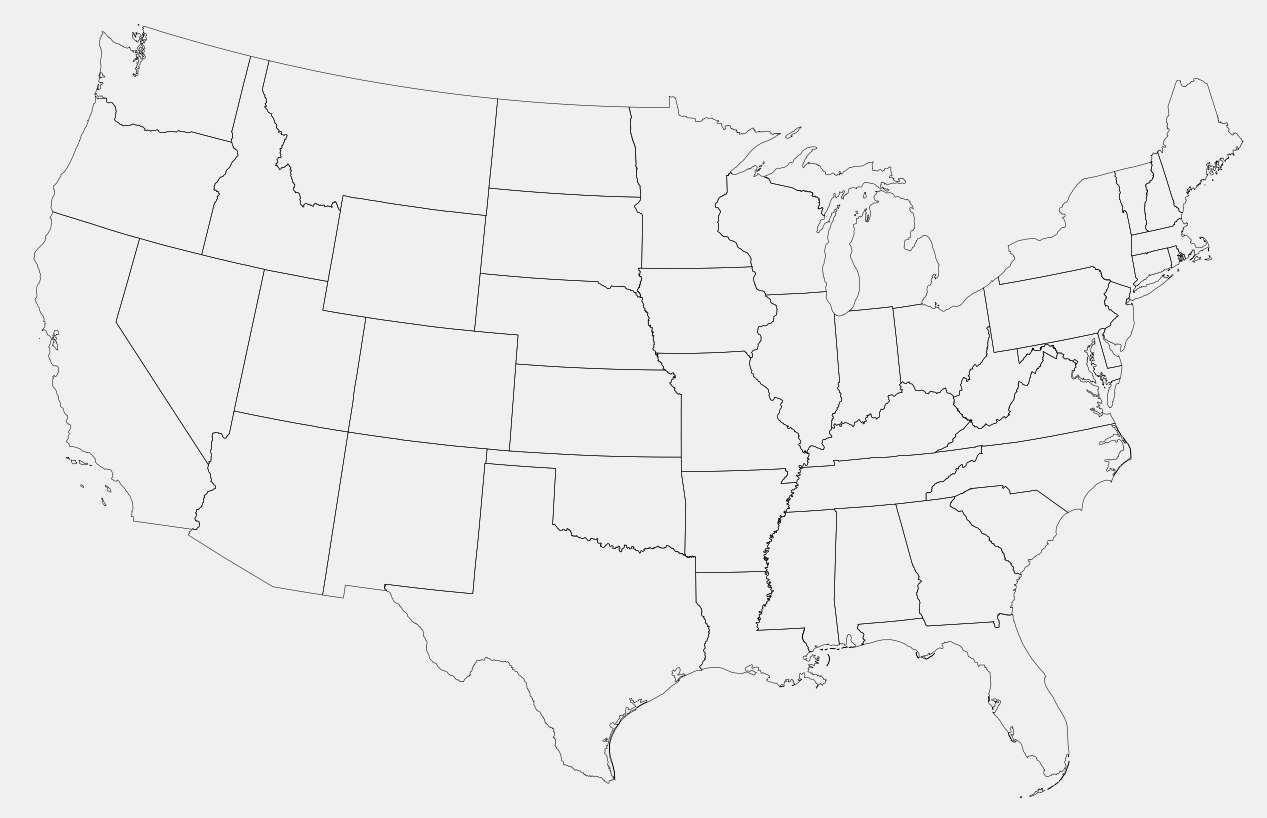

In [176]:
polarity_dict = dict(trump_polarity)

plt.subplots(figsize = (20, 16))
plt.title('Tweets Containing "Biden" by State', fontsize = 32)

# Create map
m = Basemap(llcrnrlon=-119,llcrnrlat=22,urcrnrlon=-64,urcrnrlat=49,
        projection='lcc',lat_1=33,lat_2=45,lon_0=-95)
ax = plt.gca() 
fig = plt.gcf()

# load the shapefile, use the name 'states'
m.readshapefile('../st99_d00', name='states', drawbounds=True)

# choose a color for each state based on population density.
colors={}
statenames=[]
cmap = plt.cm.Reds
patches = []
vmin = min(polarity_dict.values()); vmax = max(polarity_dict.values())
norm = Normalize(vmin=vmin, vmax=vmax)
# color mapper to covert values to colors
mapper = ScalarMappable(norm=norm, cmap=cmap)

for shapedict in m.states_info:
    statename = shapedict['NAME']
    # skip DC and Puerto Rico.
    if statename not in ['District of Columbia','Puerto Rico', 'Alaska', 'Wyoming']:
        pop = polarity_dict[statename]
        # calling colormap with value between 0 and 1 returns
        # rgba value.  Invert color range (hot colors are high
        # population), take sqrt root to spread out colors more.
        colors[statename] = cmap(np.sqrt((pop-vmin)/(vmax-vmin)))[:3]
    statenames.append(statename)
    
# cycle through state names, color each one.
for nshape,seg in enumerate(m.states):
    # skip DC and Puerto Rico.
    if statenames[nshape] not in ['District of Columbia','Puerto Rico', 'Alaska', 'Wyoming']:
#     # Offset Alaska and Hawaii to the lower-left corner. 
#         if statenames[nshape] == 'Alaska':
#         # Alaska is too big. Scale it down to 35% first, then transate it. 
#             seg = list(map(lambda x, y: (0.35*x + 1100000, 0.35*y-1300000), seg))
#         if statenames[nshape] == 'Hawaii':
#             seg = list(map(lambda x, y: (x + 5100000, y-900000), seg))

        color = rgb2hex(colors[statenames[nshape]]) 
        poly = Polygon(seg,facecolor=color,edgecolor=color)
        ax.add_patch(poly)
    else:
        pass
      
# Construct colorbar
cax = fig.add_axes([0.27, 0.05, 0.5, 0.05]) # Create new axes for colorbar for positioning purposes
cb = ColorbarBase(cax,cmap = cmap,norm = norm, orientation = 'horizontal')
cb.ax.set_xlabel('# of Tweets', labelpad = 20)

plt.show();